--- ETAP 1: Przygotowanie surowych cech ---
 -> Wczytywanie klasy: clapping...
 -> Wczytywanie klasy: footsteps...
 -> Wczytywanie klasy: doorbell...


/home/muzykos-laptop/Documents/GIThub/Projekt_badawczy_System_rozpoznawania_zdarzen_dzwiekowych_w_przestrzeni_domowej-main/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


 -> Wczytywanie klasy: vacuum_cleaner...
 -> Wczytywanie klasy: faucet...
 -> Wczytywanie klasy: hairdryer...
 -> Wczytywanie klasy: door_knock...

--- ETAP 2: Testowanie wpływu n_mfcc (1 do 50) ---
Używany wektor: [Mean MFCC, Std MFCC, Mean Delta, Std Delta]
[  0%] Przetwarzanie n_mfcc =  1 ... Celność: 56.2771%
[  1%] Przetwarzanie n_mfcc =  2 ... Celność: 70.9957%
[  2%] Przetwarzanie n_mfcc =  3 ... Celność: 76.1905%
[  2%] Przetwarzanie n_mfcc =  4 ... Celność: 77.9221%
[  2%] Przetwarzanie n_mfcc =  5 ... Celność: 80.0866%
[  3%] Przetwarzanie n_mfcc =  6 ... Celność: 79.2208%
[  4%] Przetwarzanie n_mfcc =  7 ... Celność: 81.8182%
[  4%] Przetwarzanie n_mfcc =  8 ... Celność: 81.8182%
[  4%] Przetwarzanie n_mfcc =  9 ... Celność: 79.2208%
[  5%] Przetwarzanie n_mfcc = 10 ... Celność: 78.3550%
[  6%] Przetwarzanie n_mfcc = 11 ... Celność: 79.6537%
[  6%] Przetwarzanie n_mfcc = 12 ... Celność: 80.5195%
[  6%] Przetwarzanie n_mfcc = 13 ... Celność: 80.0866%
[  7%] Przetwarzanie n_mf

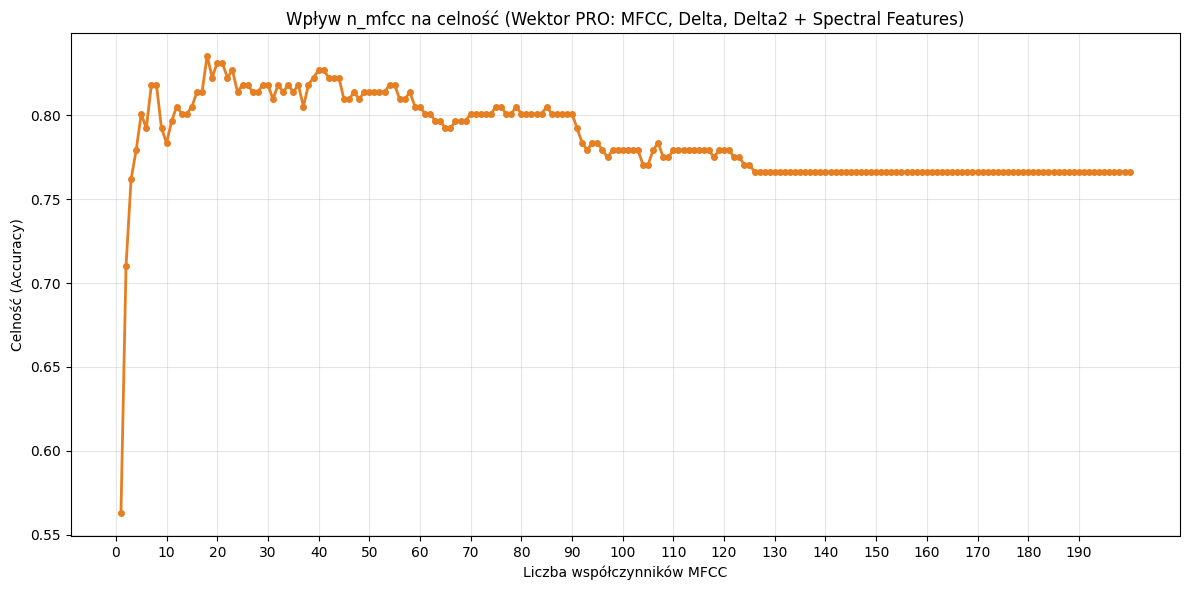

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import time

# --- Konfiguracja ---
DATA_DIR = '../../dataset/'  # Ścieżka do folderu z dźwiękami
MAX_MFCC = 200
RANDOM_STATE = 42

def load_audio_data(data_dir, max_n):
    """Wczytuje pliki i ekstrahuje maksymalną liczbę MFCC oraz ich Delt."""
    files_data = []
    labels = []
    
    print("--- ETAP 1: Przygotowanie surowych cech ---")
    all_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    for label in all_dirs:
        class_dir = os.path.join(data_dir, label)
        print(f" -> Wczytywanie klasy: {label}...")
        
        for filename in os.listdir(class_dir):
            if filename.endswith(".wav"):
                file_path = os.path.join(class_dir, filename)
                y, sr = librosa.load(file_path, sr=None)
                
                # Ekstrakcja maksymalnego zestawu cech (raz dla każdego pliku)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=max_n)
                delta = librosa.feature.delta(mfcc)
                
                files_data.append({'mfcc': mfcc, 'delta': delta})
                labels.append(label)
                
    return files_data, np.array(labels)

# 1. Wstępne ładowanie danych
start_time = time.time()
raw_features, labels_raw = load_audio_data(DATA_DIR, MAX_MFCC)

# 2. Kodowanie etykiet
le = LabelEncoder()
y = le.fit_transform(labels_raw)

# 3. Pętla testująca wpływ n_mfcc
n_range = range(1, MAX_MFCC + 1)
accuracies = []

print("\n--- ETAP 2: Testowanie wpływu n_mfcc (1 do 50) ---")
print("Używany wektor: [Mean MFCC, Std MFCC, Mean Delta, Std Delta]")

for n in n_range:
    # --- ECHO: Informacja o postępie ---
    progress = (n / MAX_MFCC) * 100
    print(f"[{progress:3.0f}%] Przetwarzanie n_mfcc = {n:2} ... ", end="", flush=True)
    
    # Tworzenie zaawansowanego wektora cech dla aktualnego n
    X = []
    for item in raw_features:
        # Przycinamy MFCC i Delty do aktualnego 'n'
        m = item['mfcc'][:n, :]
        d = item['delta'][:n, :]
        
        # Agregacja statystyk (jak w model-training.ipynb)
        vec = np.concatenate([
            np.mean(m, axis=1), # Mean MFCC
            np.std(m, axis=1),  # Std MFCC
            np.mean(d, axis=1), # Mean Delta
            np.std(d, axis=1)   # Std Delta
        ])
        X.append(vec)
    
    X = np.array(X)
    
    # Podział na zbiory
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
    )
    
    # Budowa modelu (Pipeline ze skalowaniem)
    clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1.0))
    clf.fit(X_train, y_train)
    
    # Pomiar celności
    acc = accuracy_score(y_test, clf.predict(X_test))
    accuracies.append(acc)
    
    # --- ECHO: Wynik dla danej iteracji ---
    print(f"Celność: {acc:.4%}")

total_time = time.time() - start_time
print(f"\n--- ZAKOŃCZONO ---")
print(f"Całkowity czas operacji: {total_time:.2f} sekundy.")

# 4. Wykres
plt.figure(figsize=(12, 6))
plt.plot(n_range, accuracies, marker='o', color='#e67e22', linewidth=2, markersize=4)
plt.title('Wpływ n_mfcc na celność (Wektor PRO: MFCC, Delta, Delta2 + Spectral Features)')
plt.xlabel('Liczba współczynników MFCC')
plt.ylabel('Celność (Accuracy)')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, MAX_MFCC, 10))
plt.tight_layout()
plt.show()